In [1]:
import pandas as pd
import numpy as np
import nba_api.stats.endpoints as nba
import nba_api.stats.static.players as players
import nba_api.stats.static.teams as teams
import networkx as nx
import random

In [2]:
# Helper functions
def return_id_by_nickname(nickname):
    return teams.find_teams_by_nickname(nickname)[0]['id']
def return_nickname_by_id(id):
    return teams.find_team_name_by_id(id)['nickname']
def return_player_name_by_id(id):
    return players.find_player_by_id(id)['full_name']

# These are crazy slow for big dfs
def add_full_name_column(df):
    df['full_name'] = df['PLAYER_ID'].apply(return_player_name_by_id)
    return df
def add_nickname_column(df):
    df['TEAM_NICKNAME'] = df['TEAM_ID'].apply(return_nickname_by_id)
    return df
def add_pass_to_column(df):
    df['PASS_TO'] = df['PASS_TEAMMATE_PLAYER_ID'].apply(return_player_name_by_id)

In [3]:
df = pd.read_csv('data/active_player_info_team.csv')
df

,index,id,Full_name,Firstname,Surname,Active,team_name,team_id
0,0,1630173,Precious Achiuwa,Precious,Achiuwa,True,Knicks,1610612752
1,1,203500,Steven Adams,Steven,Adams,True,Rockets,1610612745
2,2,1628389,Bam Adebayo,Bam,Adebayo,True,Heat,1610612748
3,3,1630534,Ochai Agbaji,Ochai,Agbaji,True,Raptors,1610612761
4,4,1631231,James Akinjo,James,Akinjo,True,NaN,0
...,...,...,...,...,...,...,...,...
610,610,203469,Cody Zeller,Cody,Zeller,True,Hawks,1610612737
611,611,1627826,Ivica Zubac,Ivica,Zubac,True,Clippers,1610612746
612,612,1641783,Tristan da Silva,Tristan,da Silva,True,Magic,1610612753
613,613,1628427,Vlatko Čančar,Vlatko,Čančar,True,Nuggets,1610612743


In [4]:
players_without_team = df[df['team_id'] == 0]
players_without_team.shape

(47, 8)

In [4]:
df = df[df['team_id'] != 0]
team_ids = df['team_id'].unique()
team_network = pd.DataFrame()
missing_players = []
for team_id in team_ids:
    players_on_team = df[df['team_id'] == team_id]['id'].tolist()
    for player_id in players_on_team:
        try:
            passes_made = nba.playerdashptpass.PlayerDashPtPass(team_id=team_id, player_id=player_id, season_type_all_star= 'Playoffs').get_data_frames()[0]
            team_network = pd.concat([team_network, passes_made], ignore_index=True)
        except Exception as e:
            print(f'Error getting passes for player {return_player_name_by_id(player_id)} on team {return_nickname_by_id(team_id)}')
            missing_players.append([player_id, return_player_name_by_id(player_id), team_id, return_nickname_by_id(team_id)])
            print(e)


Error getting passes for player Jaime Jaquez Jr. on team Heat
HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error getting passes for player Tre Jones on team Spurs
Expecting value: line 1 column 1 (char 0)
Error getting passes for player Tyrese Martin on team Nets
Expecting value: line 1 column 1 (char 0)
Error getting passes for player Ben Simmons on team Nets
Expecting value: line 1 column 1 (char 0)


In [ ]:
print(f'Number of missing players: {len(missing_players)}')
print(missing_players)
for player in missing_players:
    player_id = player[0]
    team_id = player[2]
    passes_made = nba.playerdashptpass.PlayerDashPtPass(team_id=team_id, player_id=player_id, season_type_all_star= 'Playoffs').get_data_frames()[0]
    team_network = pd.concat([team_network, passes_made], ignore_index=True)

Number of missing players: 14
[[1626158, 'Richaun Holmes'], [1629684, 'Grant Williams'], [1641763, 'Julian Phillips'], [1629640, 'Keldon Johnson'], [1630200, 'Tre Jones'], [1631213, 'Tyrese Martin'], [1627732, 'Ben Simmons'], [1630560, 'Cam Thomas'], [1642450, 'Daniss Jenkins'], [1630191, 'Isaiah Stewart'], [1626167, 'Myles Turner'], [1630164, 'James Wiseman'], [1629637, 'Jaxson Hayes'], [202691, 'Klay Thompson']]


TypeError: PlayerDashPtPass.__init__() missing 1 required positional argument: 'team_id'

In [5]:
team_network.to_csv('data/playoffs_third.csv', index=False)#19 players missing on PO 1st 14 on PO 2nd 4 on PO 3rd

In [6]:
nba.playerdashptpass.PlayerDashPtPass(team_id=team_id, player_id=player_id).get_data_frames()[0]

,PLAYER_ID,PLAYER_NAME_LAST_FIRST,TEAM_NAME,TEAM_ID,TEAM_ABBREVIATION,PASS_TYPE,G,PASS_TO,PASS_TEAMMATE_PLAYER_ID,FREQUENCY,...,AST,FGM,FGA,FG_PCT,FG2M,FG2A,FG2_PCT,FG3M,FG3A,FG3_PCT
0,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Dadiet, Pacôme",1642359,0.004,...,0,0,1,0.000,0,1,0.000,0,0,0.000
1,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Kolek, Tyler",1642278,0.007,...,0,0,0,0.000,0,0,0.000,0,0,0.000
2,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"McBride, Miles",1630540,0.100,...,1,3,11,0.273,2,4,0.500,1,7,0.143
3,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Ryan, Matt",1630346,0.004,...,0,0,1,0.000,0,1,0.000,0,0,0.000
4,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Brunson, Jalen",1628973,0.384,...,8,14,35,0.400,13,29,0.448,1,6,0.167
5,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Bridges, Mikal",1628969,0.114,...,10,11,16,0.688,6,7,0.857,5,9,0.556
6,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Hart, Josh",1628404,0.199,...,3,4,14,0.286,3,9,0.333,1,5,0.200
7,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Anunoby, OG",1628384,0.105,...,12,15,28,0.536,14,21,0.667,1,7,0.143
8,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Payne, Cameron",1626166,0.083,...,2,2,8,0.250,0,3,0.000,2,5,0.400


In [ ]:
lastNGames = 10
LeagueID = '00'
Month = 1
OpponentTeamID = 0
PerMode = 'Totals'
PlayerID = '2544' #LeBron James
Season = '2019-20'
SeasonType = 'Regular Season'
TeamID = '1610612747'


lebron_made = nba.playerdashptpass.PlayerDashPtPass(team_id=TeamID, player_id=PlayerID).get_data_frames()[0]
lebron_received = nba.playerdashptpass.PlayerDashPtPass(team_id=TeamID, player_id=PlayerID).get_data_frames()[1]

In [62]:
passing_stats_df = pd.read_csv('data/NBA_pass_data_2324_totals_regularseason.csv')
passing_stats_df

,Unnamed: 0,PLAYER_ID,PLAYER_NAME_LAST_FIRST,TEAM_NAME,TEAM_ID,TEAM_ABBREVIATION,PASS_TYPE,G,PASS_TO,PASS_TEAMMATE_PLAYER_ID,...,AST,FGM,FGA,FG_PCT,FG2M,FG2A,FG2_PCT,FG3M,FG3A,FG3_PCT
0,0,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Banton, Dalano",1630625,...,2,2,4,0.500,1,2,0.5,1,2,0.500
1,1,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Hauser, Sam",1630573,...,39,40,82,0.488,6,12,0.5,34,70,0.486
2,2,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Springer, Jaden",1630531,...,0,0,1,0.000,0,0,0.0,0,1,0.000
3,3,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Tillman, Xavier",1630214,...,2,2,7,0.286,0,2,0.0,2,5,0.400
4,4,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Stevens, Lamar",1630205,...,1,1,3,0.333,0,0,0.0,1,3,0.333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,3,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Flynn, Malachi",1630201,...,0,0,4,0.000,0,2,0.0,0,2,0.000
8181,4,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Wiseman, James",1630164,...,0,0,0,0.000,0,0,0.0,0,0,0.000
8182,5,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Nowell, Jaylen",1629669,...,0,0,1,0.000,0,0,0.0,0,1,0.000
8183,6,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Brown Jr., Troy",1628972,...,1,1,2,0.500,1,2,0.5,0,0,0.000


In [21]:
passing_stats_df = passing_stats_df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'TEAM_ID', 'TEAM_ABBREVIATION', 'PASS_TO', 'PASS_TEAMMATE_PLAYER_ID', 'FREQUENCY', 'PASS', 'AST']]

In [58]:
passing_stats_df = passing_stats_df[['PLAYER_ID', 'TEAM_ID', 'PASS_TEAMMATE_PLAYER_ID', 'FREQUENCY', 'PASS', 'AST']]

# Frequency Network

In [46]:
# Create a directed graph
def create_directed_graph(df, filename, write_to_file = True, weight_label = 'PASS'):
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_node(row['PLAYER_ID'], label = row['PLAYER_NAME_LAST_FIRST'], team=row['TEAM_ABBREVIATION'])
        G.add_node(row['PASS_TEAMMATE_PLAYER_ID'], label = row['PASS_TO'], team=row['TEAM_ABBREVIATION'])
        G.add_edge(row['PLAYER_ID'], row['PASS_TEAMMATE_PLAYER_ID'], weight=row[weight_label])
    if write_to_file: nx.write_gexf(G, 'networks/' + filename + '.gexf')
    return G

In [43]:
df_frequency = passing_stats_df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'PASS_TO', 'PASS_TEAMMATE_PLAYER_ID', 'FREQUENCY', 'TEAM_ABBREVIATION']]
G = create_directed_graph(df_frequency, 'passing_frequency', 'FREQUENCY')

# Flow Network

In [75]:
def create_flow_network(team_id, normalized: bool, create_network: bool = True, write_to_file = True, df = passing_stats_df):
    df_flow_all_fields = df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'PASS_TO', 'PASS_TEAMMATE_PLAYER_ID', 'PASS', 'TEAM_ID', 'TEAM_ABBREVIATION']]
    df_flow_auxiliar = df_flow_all_fields[['PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID', 'PASS', 'TEAM_ID']]
    df_flow_auxiliar = df_flow_auxiliar[df_flow_auxiliar['TEAM_ID'] == team_id]
    df_flow_inverse = df_flow_auxiliar.copy()
    df_flow_inverse.rename(columns={'PLAYER_ID': 'PASS_TEAMMATE_PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID': 'PLAYER_ID'}, inplace=True)
    df_flow_inverse['PASS'] = -df_flow_inverse['PASS']
    df_flow_total = pd.concat([df_flow_auxiliar, df_flow_inverse], ignore_index=True)
    df_flow_total = df_flow_total.groupby(['PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID', 'TEAM_ID']).sum().reset_index()
    G = None
    # Make all the values positive
    for index, row in df_flow_total.iterrows():
        if row['PASS'] < 0:
            df_flow_total.at[index, 'PASS'], df_flow_total.at[index, 'PLAYER_ID'], df_flow_total.at[index, 'PASS_TEAMMATE_PLAYER_ID'] = -row['PASS'], row['PASS_TEAMMATE_PLAYER_ID'], row['PLAYER_ID']

    df_flow_total = df_flow_total.groupby(['PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID', 'TEAM_ID']).first().reset_index() # Remove duplicates
    if normalized:
        df_flow_normalized = df_flow_total.copy()
        player_ids = df_flow_normalized['PLAYER_ID'].unique()
        for player_id in player_ids:
            player_passes = df_flow_normalized[df_flow_total['PLAYER_ID'] == player_id]
            total_passes = player_passes['PASS'].sum()
            for index, row in player_passes.iterrows():
                df_flow_normalized.at[index, 'PASS'] = row['PASS'] / total_passes

        df_flow_normalized[df_flow_normalized['PLAYER_ID'] == player_ids[0]].groupby(['PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID', 'TEAM_ID']).sum().shape
        # Delete the rows with 0 weight
        df_flow_normalized = df_flow_normalized[df_flow_normalized['PASS'] != 0]
        # Add fields from the original df
        df_flow_normalized = df_flow_normalized.merge(df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'TEAM_ABBREVIATION', 'PASS_TEAMMATE_PLAYER_ID', 'PASS_TO']], left_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'] , right_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'], how='left')

        if create_network: G = create_directed_graph(df_flow_normalized, 'flow_normalized', write_to_file=write_to_file)
        return G, df_flow_normalized
    else:
        df_flow_total = df_flow_total[df_flow_total['PASS'] != 0]
        df_flow_total = df_flow_total.merge(df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'TEAM_ABBREVIATION', 'PASS_TEAMMATE_PLAYER_ID', 'PASS_TO']], left_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'] , right_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'], how='left')
        if create_network: G = create_directed_graph(df_flow_total, 'flow_network', write_to_file=write_to_file)
        return G, df_flow_total

In [50]:
team_ids = passing_stats_df['TEAM_ID'].unique()
team_id = team_ids[2]
nickname = return_nickname_by_id(team_id)
id = return_id_by_nickname(nickname)
print(nickname, id, team_id)

Nuggets 1610612743 1610612743


In [74]:
df_all_fields = passing_stats_df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'PASS_TO', 'PASS_TEAMMATE_PLAYER_ID', 'PASS', 'TEAM_ID', 'TEAM_ABBREVIATION']]
df = df_all_fields[['PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID', 'PASS', 'TEAM_ID']]
print(df.head())
df = df.merge(df_all_fields[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'TEAM_ABBREVIATION', 'PASS_TEAMMATE_PLAYER_ID', 'PASS_TO']], left_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'] , right_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'], how='left')
print(df)
print(df_all_fields)

   PLAYER_ID  PASS_TEAMMATE_PLAYER_ID  PASS     TEAM_ID
0    1628369                  1630625    14  1610612738
1    1628369                  1630573   170  1610612738
2    1628369                  1630531     2  1610612738
3    1628369                  1630214    20  1610612738
4    1628369                  1630205     5  1610612738
      PLAYER_ID  PASS_TEAMMATE_PLAYER_ID  PASS     TEAM_ID  \
0       1628369                  1630625    14  1610612738   
1       1628369                  1630573   170  1610612738   
2       1628369                  1630531     2  1610612738   
3       1628369                  1630214    20  1610612738   
4       1628369                  1630205     5  1610612738   
...         ...                      ...   ...         ...   
8180     201959                  1630201    14  1610612765   
8181     201959                  1630164     1  1610612765   
8182     201959                  1629669     3  1610612765   
8183     201959                  1628972    

In [76]:
create_flow_network(id, normalized=False)
create_flow_network(id, normalized=True)

C:\Users\Mario\AppData\Local\Temp\ipykernel_8288\1799952105.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.028169014084507043' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_flow_normalized.at[index, 'PASS'] = row['PASS'] / total_passes


(<networkx.classes.digraph.DiGraph at 0x1a905d55f50>,
      PLAYER_ID  PASS_TEAMMATE_PLAYER_ID     TEAM_ID      PASS  \
 0       201599                   202704  1610612743  0.028169   
 1       201599                   203200  1610612743  0.126761   
 2       201599                   203484  1610612743  0.014085   
 3       201599                  1627750  1610612743  0.295775   
 4       201599                  1629008  1610612743  0.126761   
 ..         ...                      ...         ...       ...   
 98     1631221                  1631128  1610612743  0.125000   
 99     1631221                  1641816  1610612743  0.125000   
 100    1641816                   202704  1610612743  0.200000   
 101    1641816                  1629618  1610612743  0.400000   
 102    1641816                  1631124  1610612743  0.400000   
 
     PLAYER_NAME_LAST_FIRST TEAM_ABBREVIATION                    PASS_TO  
 0          Jordan, DeAndre               DEN            Jackson, Reggie  
 1

In [13]:
G = nx.Graph()
G.add_node('GOAL', attr='Goal')

In [14]:
for index, row in passing_stats_df.iterrows():
    player = row['PLAYER_NAME_LAST_FIRST']
    team = row['TEAM_NAME']
    if not G.has_node(player):
        G.add_node(player, attr=team)

In [15]:
for index, row in passing_stats_df.iterrows():
    edge = (row['PLAYER_NAME_LAST_FIRST'], row['PASS_TO'])
    weight = row['PASS']
    if G.has_edge(*edge):
        # If the edge exists, add to the current weight
        G[edge[0]][edge[1]]['weight'] += weight    
    else:
        G.add_edge(edge[0], edge[1], weight=weight)

In [ ]:
# GET THE DATASET FOR THE POINTS
df = df[df['team_id'] != 0]
team_ids = df['team_id'].unique()
team_network = pd.DataFrame()
missing_players = []
for team_id in team_ids:
    players_on_team = df[df['team_id'] == team_id]['id'].tolist()
    for player_id in players_on_team:
        try:
            passes_made = nba.playerdashptpass.PlayerDashPtPass(team_id=team_id, player_id=player_id, season_type_all_star= 'Playoffs').get_data_frames()[0]
            player_stats = nba.leaguedashplayerstats.LeagueDashPlayerStats(per_mode_detailed='PerGame', season='2019-20').get_data_frames()[0]
            team_network = pd.concat([team_network, player_stats], ignore_index=True)
        except Exception as e:
            print(f'Error getting passes for player {return_player_name_by_id(player_id)} on team {return_nickname_by_id(team_id)}')
            missing_players.append([player_id, return_player_name_by_id(player_id), team_id, return_nickname_by_id(team_id)])
            print(e)


In [ ]:
def add_hoop_stochastic(df_passes, df_points):
    G.add_node('3Pt', attr='3Pt')
    G.add_node('2Pt', attr='2Pt')
    G.add_node('FT', attr='FT')
    G.add_node('TO', attr='TO')
    G.add_node('Missed', attr='Missed')
    G.add_node('Team1Out', attr='Team1Out')
    G.add_node('Team2Out', attr='Team2Out')
    player_ids = df_passes['PLAYER_ID'].unique()
    for player_id in player_ids:
        points_player = df_points[df_points['PLAYER_ID'] == player_id]
        passes_player = df_passes[df_passes['PLAYER_ID'] == player_id]
        total_passes = passes_player['PASS'].sum()
        total_FGM = points_player['FGM'].sum()
        total_FGA = points_player['FGA'].sum()
        total_3PM = points_player['FG3M'].sum()
        total_3PA = points_player['FG3A'].sum()
        total_2PM = total_FGM - total_3PM
        total_FTM = points_player['FTM'].sum()
        total_TOV = points_player['TOV'].sum() # Whats the steal/turnover ratio?
        
        total_actions = total_passes + total_FGA + total_FTA + total_TOV # I think 3PA is included in FGA
        G.add_edge(player_id, '3Pt', weight=total_3PA/total_actions)
        G.add_edge(player_id, '2Pt', weight=(total_FGA - total_3PA)/total_actions)
        G.add_edge(player_id, 'FT', weight=total_FTA/total_actions)

        
        

        

In [ ]:
stochastic_G = nx.stochastic_graph(G, weight='weight')

def stochastic_random_walk(G, start_node, num_steps):
    walk = [start_node]  # Initialize the walk
    current_node = start_node
    
    for _ in range(num_steps):
        neighbors = list(G.neighbors(current_node))
        if not neighbors:  # Stop if no neighbors
            break
        
        # Get normalized weights (from the stochastic graph)
        weights = [G[current_node][neighbor].get('weight', 1) for neighbor in neighbors]
        
        # Choose the next node based on the weights
        current_node = random.choices(neighbors, weights=weights, k=1)[0]
        walk.append(current_node)
    
    return walk

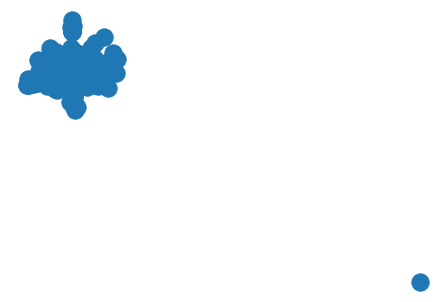

In [16]:
nx.draw(G)